# PROBLEM STATEMENT 

# DATA COLLECTION

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

data = pd.read_csv("Articles.csv", encoding="latin1")


# DATA CLEANING

In [28]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


In [38]:



# Simple checks 
print("shape of the dataset:", data.shape) #How many rows and columns do you have?
print("How many articles?", len(data)) #How big is your dataset? 
print("What columns do I have?", data.columns.tolist())
print("Any missing data?", data.isnull().sum()) #Are there any gaps in your data?


shape of the dataset: (2692, 5)
How many articles? 2692
What columns do I have? ['Article', 'Date', 'Heading', 'NewsType', 'text']
Any missing data? Article     0
Date        0
Heading     0
NewsType    0
text        0
dtype: int64


# EDA 


Top News Types:
NewsType
sports      1408
business    1284
Name: count, dtype: int64


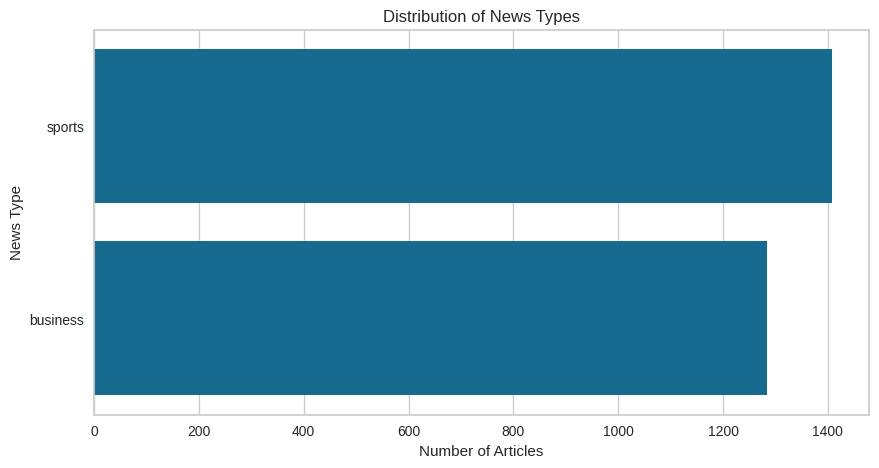

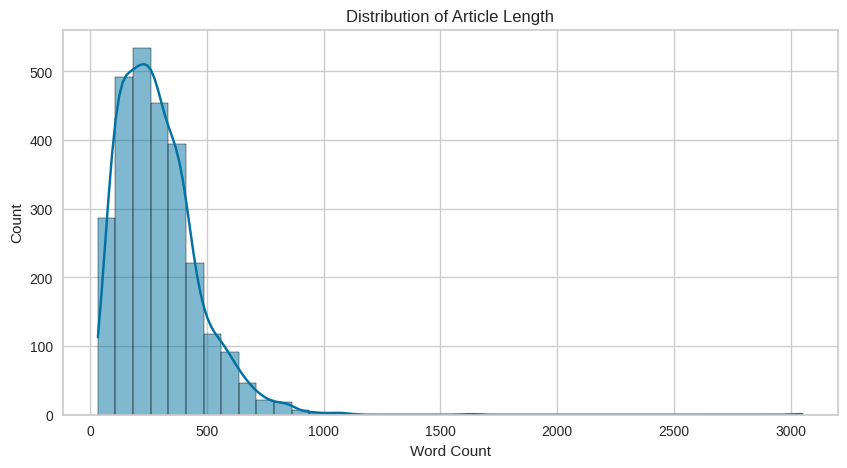

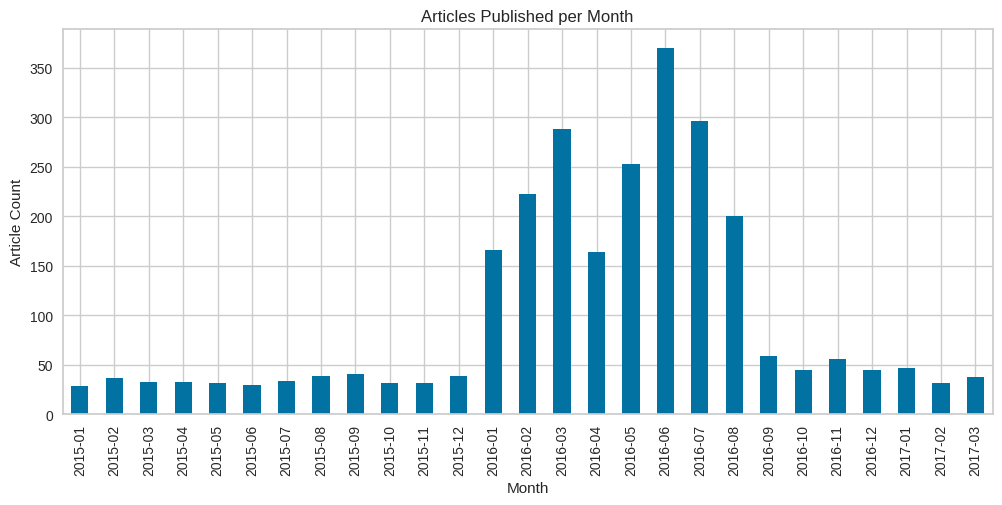

KeyError: 'label'

In [30]:


# --- Univariate Analysis ---
print("Top News Types:")
print(data['NewsType'].value_counts())

# Plot News Type distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=data, y='NewsType', order=data['NewsType'].value_counts().index)
plt.title("Distribution of News Types")
plt.xlabel("Number of Articles")
plt.ylabel("News Type")
plt.show()

# Article length analysis
data['ArticleLength'] = data['Article'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 5))
sns.histplot(data['ArticleLength'], bins=40, kde=True)
plt.title("Distribution of Article Length")
plt.xlabel("Word Count")
plt.show()

# Time trend (articles per month)
data['Month'] = data['Date'].dt.to_period('M')
monthly_counts = data['Month'].value_counts().sort_index()
monthly_counts.plot(kind='bar', figsize=(12, 5), title="Articles Published per Month")
plt.ylabel("Article Count")
plt.show()


# Plot the distribution of labels
plt.hist(data['label'], bins=len(data['label'].unique()))
plt.title('Distribution of Article Labels')
plt.xlabel('Label')
plt.ylabel('Number of Articles')
plt.show()
# When are articles most frequently published?
data['hour'] = data['Date'].dt.hour
hourly_counts = data['hour'].value_counts().sort_index()

plt.plot(hourly_counts.index, hourly_counts.values, marker='o')
plt.title('Number of Articles Published by Hour')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Articles')
plt.show()

# FEATURE ENGINEERING

(2692, 10)
Index(['Article', 'Date', 'Heading', 'NewsType', 'ArticleLength', 'Month',
       'HeadingLength', 'Sentiment', 'DayOfWeek', 'IsWeekend'],
      dtype='object')
NewsType
sports      1408
business    1284
Name: count, dtype: int64
count     2692.000000
mean      1859.129643
std       1080.577162
min        259.000000
25%       1083.000000
50%       1694.000000
75%       2379.000000
max      19242.000000
Name: text_length, dtype: float64


<Axes: xlabel='NewsType', ylabel='count'>

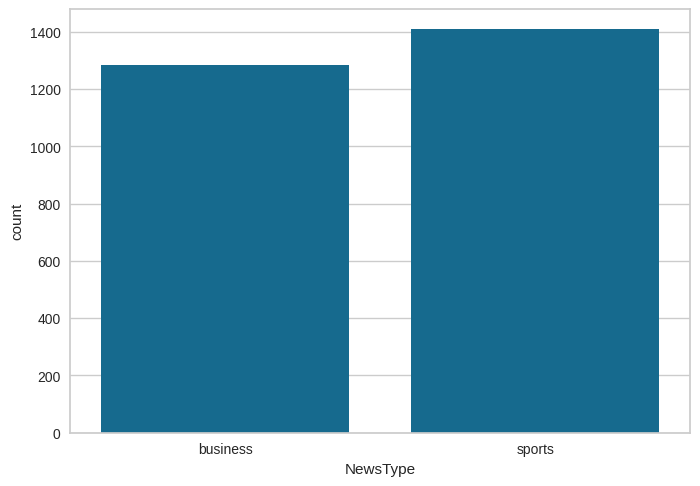

In [31]:

# Ensure 'Date' is datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Feature: Headline Length
data['HeadingLength'] = data['Heading'].apply(lambda x: len(str(x)))

# Feature: Article Sentiment Polarity
data['Sentiment'] = data['Article'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Feature: Day of Week
data['DayOfWeek'] = data['Date'].dt.day_name()

# Feature: Is Weekend
data['IsWeekend'] = data['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)

# Preview new features
data[['HeadingLength', 'Sentiment', 'DayOfWeek', 'IsWeekend']].head()
# Basic overview
print(data.shape)
print(data.columns)
print(data['NewsType'].value_counts())

# Length of text entries
data['text'] = data['Heading'].astype(str) + ". " + data['Article'].astype(str)
data['text_length'] = data['text'].apply(len)
print(data['text_length'].describe())

# Visualize label distribution
sns.countplot(x=data['NewsType'])



# MODEL SELECTION

In [ ]:
from pycaret.classification import *
data = pd.read_csv("Articles.csv", encoding="latin1")

# Optional: Combine heading + article to enrich context (better NLP signal)
data['text'] = data['Heading'].astype(str) + ". " + data['Article'].astype(str)

# Set up PyCaret
clf_setup = setup(
    data=data,
    target='NewsType',
    session_id=42,
    text_features=['text'],   # 👈 Tell PyCaret to treat this as NLP
    ignore_features=['Article', 'Heading', 'Date'],  # Drop original columns
)

# Compare models and select the best one
best_model = compare_models(exclude=['lda'])

# Predict on the same dataset or new one
preds = predict_model(best_model)

# Save model
save_model(best_model, 'best_news_classifier')


,Description,Value
0,Session id,42
1,Target,NewsType
2,Target type,Binary
3,Target mapping,"business: 0, sports: 1"
4,Original data shape,"(2692, 5)"
5,Transformed data shape,"(2692, 24299)"
6,Transformed train set shape,"(1884, 24299)"
7,Transformed test set shape,"(808, 24299)"
8,Ignore features,3
9,Text features,1


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:14:57
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Quadratic Discriminant Analysis


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9979,0.9997,0.9979,0.9979,0.9979,0.9957,0.9958,5.7650
ridge,Ridge Classifier,0.9963,0.9999,0.9963,0.9963,0.9963,0.9926,0.9926,3.1710
svm,SVM - Linear Kernel,0.9958,0.9999,0.9958,0.9958,0.9958,0.9915,0.9915,2.0280
rf,Random Forest Classifier,0.9931,0.9994,0.9931,0.9931,0.9931,0.9862,0.9862,2.6350
knn,K Neighbors Classifier,0.9888,0.9987,0.9888,0.9890,0.9888,0.9776,0.9778,2.4120
nb,Naive Bayes,0.9841,0.9841,0.9841,0.9842,0.9841,0.9681,0.9682,2.2340
dt,Decision Tree Classifier,0.9443,0.9446,0.9443,0.9449,0.9443,0.8884,0.8890,1.8620


Processing:   0%|          | 0/57 [00:00<?, ?it/s]

KeyboardInterrupt: 

# MODEL TRAINING 

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier



# Vectorize text
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['text'])
y = data['NewsType']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
lr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
ridge = RidgeClassifier().fit(X_train, y_train)
svm = SVC(kernel='linear').fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

# Models are now trained and ready for predictions

## logistic regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# prepare data
x_train,x_test,y_train,y_test = train_test_split()
x,y,test_size=0.2,random_number=42
# define models
models={
    "Logistic Rgression" : LogisticRegression(),
    "Random Forest" : RandomForestClassifier()
}
# loop through the models 
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f "{name} Accuracy: {accurancy:.2f}")


Accuracy: 0.9925788497217068

Classification Report:
               precision    recall  f1-score   support

    business       0.99      1.00      0.99       262
      sports       1.00      0.99      0.99       277

    accuracy                           0.99       539
   macro avg       0.99      0.99      0.99       539
weighted avg       0.99      0.99      0.99       539



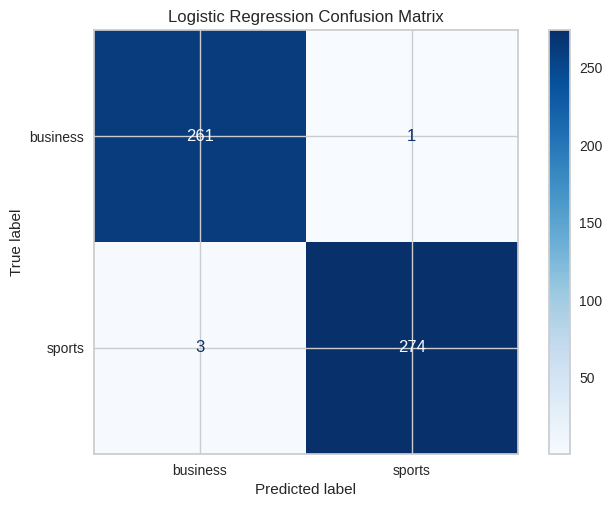

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("Articles.csv", encoding="latin1")
data['text'] = data['Heading'].astype(str) + ". " + data['Article'].astype(str)

# Vectorize text
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['text'])
y = data['NewsType']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Test model
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# MODEL EVALUATION

In [41]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score


models = {
    "Logistic Regression": lr,
    "Ridge Classifier": ridge,
    "SVM - Linear Kernel": svm,
    "Random Forest Classifier": rf
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("Kappa:", cohen_kappa_score(y_test, y_pred))
    print("MCC:", matthews_corrcoef(y_test, y_pred))
    # AUC for multiclass (if model supports predict_proba)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        auc = roc_auc_score(pd.get_dummies(y_test), y_proba, average='macro', multi_class='ovr')
        print("AUC:", auc)
    else:
        print("AUC: Not available for this model")


Logistic Regression
Accuracy: 0.9925788497217068
Recall: 0.9926764405985615
Precision: 0.9924999999999999
F1 Score: 0.9925745302253817
Kappa: 0.9851492650401577
MCC: 0.9851764247987088
AUC: 0.9998484305674209

Ridge Classifier
Accuracy: 0.9962894248608535
Recall: 0.9962865489018106
Precision: 0.9962865489018106
F1 Score: 0.9962865489018106
Kappa: 0.9925730978036211
MCC: 0.9925730978036211
AUC: Not available for this model

SVM - Linear Kernel
Accuracy: 0.9981447124304267
Recall: 0.9980916030534351
Precision: 0.9982014388489209
F1 Score: 0.9981430761545484
Kappa: 0.9962861651037325
MCC: 0.9962930358479615
AUC: Not available for this model

Random Forest Classifier
Accuracy: 0.9925788497217068
Recall: 0.9926764405985615
Precision: 0.9924999999999999
F1 Score: 0.9925745302253817
Kappa: 0.9851492650401577
MCC: 0.9851764247987088
AUC: 0.9996624135365283



Logistic Regression Confusion Matrix:


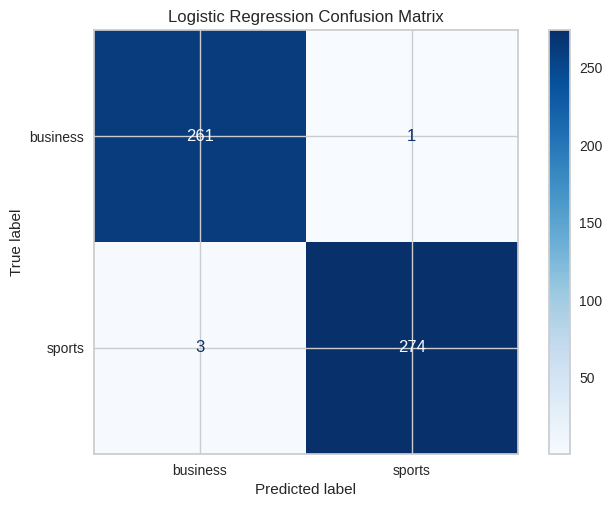


Ridge Classifier Confusion Matrix:


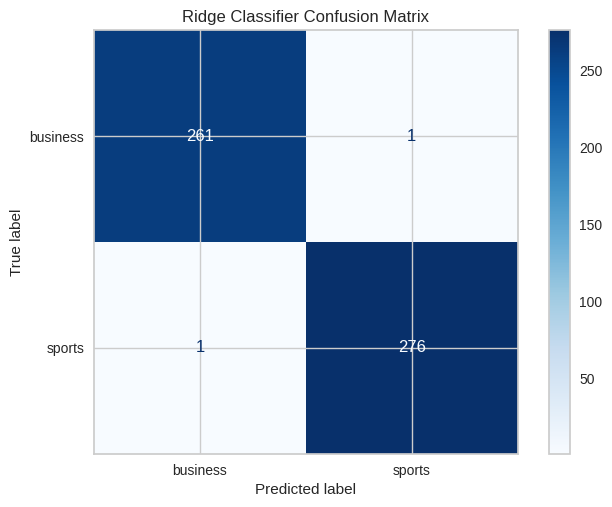


SVM - Linear Kernel Confusion Matrix:


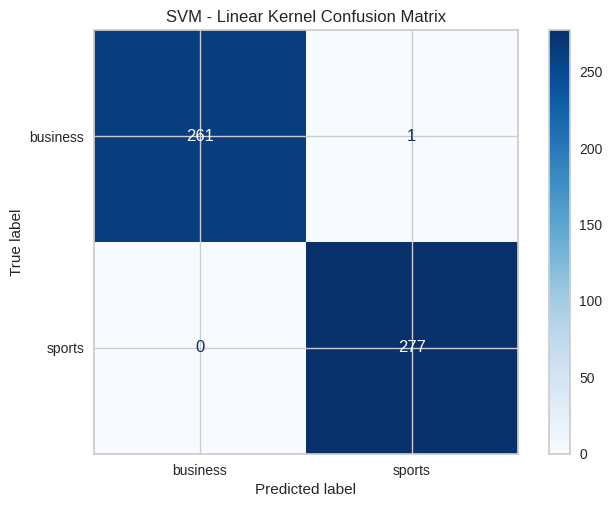


Random Forest Classifier Confusion Matrix:


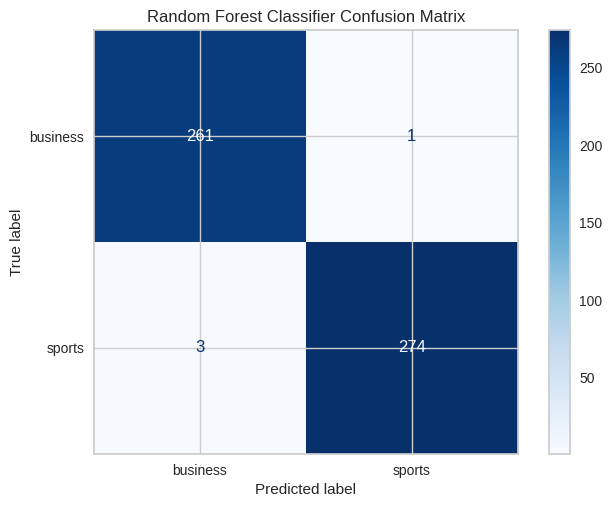

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()